In [1]:
import pandas as pd
import numpy as np
import psycopg2



In [2]:
# password = config.password


In [32]:
connection = psycopg2.connect(
    user="postgres",
    password="12345",
    host="127.0.0.1",
    port="5432",
    database="AIS_Project")

cursor = connection.cursor()

cursor.execute(f'''
WITH "convert_query" as (
    SELECT to_char("BaseDateTime", 'YYYY-mm-dd') as "date", "MMSI", "VesselType"
    FROM "ais_raw_data"),
    
    "unique_search" as (
    SELECT DISTINCT("date", "MMSI", "VesselType") as "test", "date", "VesselType" FROM "convert_query"
    GROUP BY "test", "date", "VesselType")

SELECT "date", "VesselType", Count("VesselType") 
FROM unique_search
GROUP BY "date", "VesselType"
ORDER BY "date";
''')

record = cursor.fetchall()

data_df = pd.DataFrame(record, columns=["basedatetime", "vesseltype", "count"])
data_df = data_df.set_index("basedatetime")
data_df

,vesseltype,count
basedatetime,,
2018-01-01,70.0,27
2018-01-01,69.0,1
2018-01-01,52.0,1
2018-01-01,80.0,13
2018-01-01,36.0,26
...,...,...
2022-03-31,99.0,2
2022-03-31,59.0,1
2022-03-31,89.0,1


In [33]:
unique_dates = []
unique_vt = []
for x in data_df.index:
    if x not in unique_dates:
        unique_dates.append(x)
 
for x in data_df["vesseltype"]:
    if x not in unique_vt:
        unique_vt.append(x)


In [34]:
AIS_df = pd.DataFrame(columns=["Total", "Fishing", "TugTow", "Recreational", "Passenger", "Cargo", "Tanker", "Other", "Unavailable"], index=unique_dates)

In [35]:
AIS_df.head()

zero_data = np.zeros(shape=(len(AIS_df), len(AIS_df.columns)))

AIS_df = pd.DataFrame(zero_data, columns=["Total", "Fishing", "TugTow", "Recreational", "Passenger", "Cargo", "Tanker", "Other", "Unavailable"], index=unique_dates)


In [36]:
for index, row in enumerate(AIS_df.index):
    search_result = data_df.loc[row]
    for index, row in search_result.iterrows():
        AIS_df.loc[index, "Total"] += row[1]
        if row[0] == 30:
            AIS_df.loc[index, "Fishing"] += row[1]
        elif (row[0] == 31) or (row[0] == 32) or (row[0] == 52):
            AIS_df.loc[index, "TugTow"] += row[1]
        elif (row[0] == 36) or (row[0] == 37):
            AIS_df.loc[index, "Recreational"] += row[1]
        elif (row[0] >=60) and (row[0] <= 69):
            AIS_df.loc[index, "Passenger"] += row[1]
        elif (row[0] >=70) and (row[0] <= 79):
            AIS_df.loc[index, "Cargo"] += row[1]
        elif (row[0] >=80) and (row[0] <= 89):
            AIS_df.loc[index, "Tanker"] += row[1]
        elif (row[0] == 0):
            AIS_df.loc[index, "Unavailable"] += row[1]
        else: AIS_df.loc[index, "Other"] += row[1]


In [37]:
AIS_df.reset_index(inplace=True)
AIS_df

,index,Total,Fishing,TugTow,Recreational,Passenger,Cargo,Tanker,Other,Unavailable
0,2018-01-01,294.0,9.0,37.0,145.0,44.0,27.0,13.0,12.0,7.0
1,2018-01-02,288.0,13.0,45.0,119.0,41.0,27.0,14.0,19.0,10.0
2,2018-01-03,284.0,13.0,44.0,106.0,40.0,36.0,14.0,20.0,11.0
3,2018-01-04,274.0,15.0,44.0,103.0,45.0,30.0,10.0,15.0,12.0
4,2018-01-05,273.0,10.0,45.0,107.0,41.0,26.0,13.0,21.0,10.0
...,...,...,...,...,...,...,...,...,...,...
1543,2022-03-27,503.0,10.0,46.0,308.0,54.0,46.0,10.0,24.0,5.0
1544,2022-03-28,454.0,13.0,51.0,248.0,54.0,44.0,11.0,29.0,4.0
1545,2022-03-29,404.0,11.0,43.0,209.0,50.0,43.0,11.0,33.0,4.0
1546,2022-03-30,388.0,9.0,45.0,195.0,53.0,42.0,11.0,29.0,4.0


<AxesSubplot:xlabel='index'>

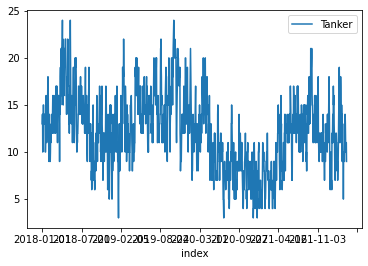

In [38]:
AIS_df.plot(x="index", y="Tanker")

In [39]:
AIS_df.to_csv("Full_Result_daily.csv", index=False)